In [1]:
from tg.common.ml import batched_training as bt
from tg.grammar_ru import *
from tqdm import tqdm
import pandas as pd
import numpy as np
import torch

In [2]:
class CommonTuningNetwork(torch.nn.Module):
    def __init__(self, Wtrained: torch.Tensor, Btrained: torch.Tensor, Wc_trained: torch.Tensor, Bc_trained: torch.Tensor):
        super(CommonTuningNetwork, self).__init__()
        self.Wtrained = torch.nn.Embedding.from_pretrained(Wtrained)
        self.Btrained = torch.nn.Embedding.from_pretrained(Btrained)
        self.Wc_trained = torch.nn.Embedding.from_pretrained(Wc_trained)
        self.Bc_trained = torch.nn.Embedding.from_pretrained(Bc_trained)
        self.W = torch.nn.Embedding(num_embeddings=Wtrained.shape[0], embedding_dim=Wtrained.shape[1])
        self.b = torch.nn.Embedding(num_embeddings=Btrained.shape[0], embedding_dim=Btrained.shape[1])
        self.Wc = torch.nn.Embedding(num_embeddings=Wtrained.shape[0], embedding_dim=Wtrained.shape[1])
        self.bc = torch.nn.Embedding(num_embeddings=Btrained.shape[0], embedding_dim=Btrained.shape[1])
        
    def forward(self, batch):
        word_and = batch['input'].word_nonce.all()
        context_and = batch['input'].context_nonce.all()
        if word_and and not context_and:
            return self.common_forward(batch, self.W, self.b, self.Wc_trained, self.Bc_trained)
        if not word_and and context_and:
            return self.common_forward(batch, self.Wtrained, self.Btrained, self.Wc, self.bc)
        if word_and and context_and:
            return self.common_forward(batch, self.W, self.b, self.Wc, self.bc)
        
    def common_forward(self, batch, w, b, w_c, b_c):
        W_c = w_c(torch.LongTensor(batch['input'].context_nf_index.values))
        B_c = b_c(torch.LongTensor(batch['input'].context_nf_index.values))
        W = w(torch.LongTensor(batch['input'].nf_index.values))
        B = b(torch.LongTensor(batch['input'].nf_index.values))
        return torch.sum((W_c * W), dim=1).unsqueeze(1) + B_c + B

In [3]:
FOLDER = Loc.data_cache_path/'Rowling'

vectors_file =FOLDER/'glove'/'output.txt'
vectors_df = pd.read_csv(vectors_file, sep=' ',header=None).set_index(0)
vectors_df = vectors_df.reset_index(drop=True).iloc[:-1]
vectors_df.columns=list(range(vectors_df.shape[1]))
vectors_df.index.name='index'

tuning_candidates = pd.read_csv(Loc.data_cache_path/'tuning_candidates.csv', sep='\t').set_index('nf_n')
cooc_pairs = pd.read_csv(FOLDER/'Rowling_cooc.cvs').drop(columns='Unnamed: 0')
common_cooc = cooc_pairs[['nf_index', 'context_nf_index', 'label']]

w_ = vectors_df.iloc[:, :300]
bias_ = vectors_df.iloc[:, 300]
w_c = vectors_df.iloc[:, 301:601].reset_index(drop=True)
bias_c = vectors_df.iloc[:, 601]

all_freq_nnf = tuning_candidates[tuning_candidates.in_freq_prop | 
                                 tuning_candidates.is_name_by_cnt | 
                                 tuning_candidates.is_nonce_by_freq].index.values

batch_size = 4000

In [4]:
def round_up_df(df, batch_size):
    rem = batch_size - df.shape[0] % batch_size
    return pd.concat([df, df.sample(n=rem)])


nonce_in_regular_context = (common_cooc[common_cooc['nf_index'].isin(all_freq_nnf) & 
                                        ~common_cooc['context_nf_index'].isin(all_freq_nnf)])
nonce_in_regular_context = round_up_df(nonce_in_regular_context, batch_size)
nonce_in_regular_context['word_nonce'] = True
nonce_in_regular_context['context_nonce'] = False 

regular_in_nonce_context = (common_cooc[~common_cooc['nf_index'].isin(all_freq_nnf) & 
                                        common_cooc['context_nf_index'].isin(all_freq_nnf)])
regular_in_nonce_context = round_up_df(regular_in_nonce_context, batch_size)
regular_in_nonce_context['word_nonce'] = False
regular_in_nonce_context['context_nonce'] = True

nonce_in_nonce_context = (common_cooc[common_cooc['nf_index'].isin(all_freq_nnf) & 
                                      common_cooc['context_nf_index'].isin(all_freq_nnf)])
nonce_in_nonce_context = round_up_df(nonce_in_nonce_context, batch_size)
nonce_in_nonce_context['word_nonce'] = True
nonce_in_nonce_context['context_nonce'] = True

nonce_db = DataBundle(index_frame=pd.concat([nonce_in_regular_context, 
                                             regular_in_nonce_context,
                                             nonce_in_nonce_context]).reset_index(drop=True))
del nonce_in_regular_context
del regular_in_nonce_context
del nonce_in_nonce_context
idb = bt.IndexedDataBundle(
    index_frame = nonce_db.index_frame,
    bundle = nonce_db
)

input_extractor = bt.PlainExtractor.build('input').index().apply(take_columns=['nf_index', 
                                                                               'context_nf_index', 
                                                                               'word_nonce', 
                                                                               'context_nonce'])
label_extractor = bt.PlainExtractor.build('label').index().apply(take_columns='label')
bb = bt.Batcher(batch_size=batch_size, extractors=[input_extractor, label_extractor])

In [5]:
def train_loop(model, loss_fn, optimizer, idb, batcher):
    t_loss = 0
    n = batcher.get_batch_count(idb)
    for batch_index in tqdm(range(n)):
        batch = batcher.get_batch(idb, batch_index)
        pred = model(batch)
        loss = loss_fn(pred, torch.tensor(batch['label'].values, dtype=torch.float32))
        
        optimizer.zero_grad()
        loss.backward()
        t_loss += loss.item()
        optimizer.step()
    return t_loss / n

def train(name_idb, network, batcher):
        total_loss = []
        optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
        epochs = 300
        for t in range(epochs):
            print(f"Epoch {t+1}\n-------------------------------")
            loss = train_loop(network, torch.nn.MSELoss(), optimizer, name_idb, batcher)
            total_loss.append(loss)
        print("Done!")
        return total_loss

     
netw = CommonTuningNetwork(torch.Tensor(w_.values),
                           torch.Tensor(bias_.values).unsqueeze(1),
                           torch.Tensor(w_c.values),
                           torch.Tensor(bias_c.values).unsqueeze(1))
tl = train(idb, netw, bb)

Epoch 1
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [01:08<00:00,  2.18it/s]


Epoch 2
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:50<00:00,  2.94it/s]


Epoch 3
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:48<00:00,  3.09it/s]


Epoch 4
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:52<00:00,  2.85it/s]


Epoch 5
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:55<00:00,  2.70it/s]


Epoch 6
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:59<00:00,  2.51it/s]


Epoch 7
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:49<00:00,  3.03it/s]


Epoch 8
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:48<00:00,  3.10it/s]


Epoch 9
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:48<00:00,  3.10it/s]


Epoch 10
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:48<00:00,  3.06it/s]


Epoch 11
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:51<00:00,  2.88it/s]


Epoch 12
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:47<00:00,  3.17it/s]


Epoch 13
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:46<00:00,  3.18it/s]


Epoch 14
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:46<00:00,  3.21it/s]


Epoch 15
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:47<00:00,  3.11it/s]


Epoch 16
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:46<00:00,  3.17it/s]


Epoch 17
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:46<00:00,  3.18it/s]


Epoch 18
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:46<00:00,  3.17it/s]


Epoch 19
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:49<00:00,  3.01it/s]


Epoch 20
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:58<00:00,  2.54it/s]


Epoch 21
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:45<00:00,  3.28it/s]


Epoch 22
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:46<00:00,  3.23it/s]


Epoch 23
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:46<00:00,  3.19it/s]


Epoch 24
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:47<00:00,  3.16it/s]


Epoch 25
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:42<00:00,  3.47it/s]


Epoch 26
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:43<00:00,  3.40it/s]


Epoch 27
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:43<00:00,  3.39it/s]


Epoch 28
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:45<00:00,  3.31it/s]


Epoch 29
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:46<00:00,  3.18it/s]


Epoch 30
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:51<00:00,  2.89it/s]


Epoch 31
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:50<00:00,  2.94it/s]


Epoch 32
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:50<00:00,  2.96it/s]


Epoch 33
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:49<00:00,  3.02it/s]


Epoch 34
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:50<00:00,  2.93it/s]


Epoch 35
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:45<00:00,  3.28it/s]


Epoch 36
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:45<00:00,  3.26it/s]


Epoch 37
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:45<00:00,  3.25it/s]


Epoch 38
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [01:19<00:00,  1.88it/s]


Epoch 39
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [01:24<00:00,  1.76it/s]


Epoch 40
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:49<00:00,  2.98it/s]


Epoch 41
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:45<00:00,  3.31it/s]


Epoch 42
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:46<00:00,  3.20it/s]


Epoch 43
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:48<00:00,  3.08it/s]


Epoch 44
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:46<00:00,  3.18it/s]


Epoch 45
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:51<00:00,  2.91it/s]


Epoch 46
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:54<00:00,  2.74it/s]


Epoch 47
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:49<00:00,  3.00it/s]


Epoch 48
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:49<00:00,  2.99it/s]


Epoch 49
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:47<00:00,  3.11it/s]


Epoch 50
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:55<00:00,  2.70it/s]


Epoch 51
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:58<00:00,  2.54it/s]


Epoch 52
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:44<00:00,  3.35it/s]


Epoch 53
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:43<00:00,  3.39it/s]


Epoch 54
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:46<00:00,  3.21it/s]


Epoch 55
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:47<00:00,  3.12it/s]


Epoch 56
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:56<00:00,  2.63it/s]


Epoch 57
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:50<00:00,  2.94it/s]


Epoch 58
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:46<00:00,  3.17it/s]


Epoch 59
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:47<00:00,  3.11it/s]


Epoch 60
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:49<00:00,  3.02it/s]


Epoch 61
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:47<00:00,  3.11it/s]


Epoch 62
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:52<00:00,  2.81it/s]


Epoch 63
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:49<00:00,  3.01it/s]


Epoch 64
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [01:00<00:00,  2.47it/s]


Epoch 65
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [01:04<00:00,  2.29it/s]


Epoch 66
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [01:06<00:00,  2.26it/s]


Epoch 67
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:56<00:00,  2.64it/s]


Epoch 68
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:52<00:00,  2.86it/s]


Epoch 69
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:51<00:00,  2.89it/s]


Epoch 70
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:52<00:00,  2.83it/s]


Epoch 71
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:53<00:00,  2.81it/s]


Epoch 72
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:51<00:00,  2.89it/s]


Epoch 73
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:51<00:00,  2.89it/s]


Epoch 74
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:51<00:00,  2.92it/s]


Epoch 75
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:50<00:00,  2.95it/s]


Epoch 76
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:51<00:00,  2.90it/s]


Epoch 77
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:50<00:00,  2.95it/s]


Epoch 78
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:50<00:00,  2.98it/s]


Epoch 79
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:49<00:00,  3.01it/s]


Epoch 80
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:46<00:00,  3.21it/s]


Epoch 81
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:50<00:00,  2.95it/s]


Epoch 82
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:48<00:00,  3.05it/s]


Epoch 83
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:48<00:00,  3.09it/s]


Epoch 84
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:50<00:00,  2.95it/s]


Epoch 85
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:50<00:00,  2.95it/s]


Epoch 86
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:52<00:00,  2.85it/s]


Epoch 87
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:50<00:00,  2.95it/s]


Epoch 88
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:51<00:00,  2.92it/s]


Epoch 89
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:51<00:00,  2.89it/s]


Epoch 90
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:47<00:00,  3.15it/s]


Epoch 91
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:46<00:00,  3.23it/s]


Epoch 92
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:44<00:00,  3.34it/s]


Epoch 93
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:43<00:00,  3.42it/s]


Epoch 94
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:43<00:00,  3.41it/s]


Epoch 95
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:43<00:00,  3.43it/s]


Epoch 96
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:43<00:00,  3.40it/s]


Epoch 97
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:43<00:00,  3.42it/s]


Epoch 98
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:43<00:00,  3.40it/s]


Epoch 99
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:43<00:00,  3.39it/s]


Epoch 100
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:45<00:00,  3.31it/s]


Epoch 101
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:45<00:00,  3.30it/s]


Epoch 102
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:43<00:00,  3.39it/s]


Epoch 103
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:43<00:00,  3.40it/s]


Epoch 104
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:43<00:00,  3.40it/s]


Epoch 105
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:51<00:00,  2.87it/s]


Epoch 106
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:45<00:00,  3.30it/s]


Epoch 107
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:44<00:00,  3.32it/s]


Epoch 108
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:45<00:00,  3.30it/s]


Epoch 109
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:45<00:00,  3.30it/s]


Epoch 110
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:45<00:00,  3.24it/s]


Epoch 111
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:47<00:00,  3.12it/s]


Epoch 112
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:47<00:00,  3.11it/s]


Epoch 113
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:50<00:00,  2.94it/s]


Epoch 114
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:49<00:00,  3.00it/s]


Epoch 115
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:50<00:00,  2.95it/s]


Epoch 116
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:48<00:00,  3.08it/s]


Epoch 117
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:45<00:00,  3.27it/s]


Epoch 118
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:45<00:00,  3.29it/s]


Epoch 119
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:45<00:00,  3.25it/s]


Epoch 120
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:45<00:00,  3.26it/s]


Epoch 121
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:51<00:00,  2.90it/s]


Epoch 122
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:50<00:00,  2.93it/s]


Epoch 123
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:46<00:00,  3.18it/s]


Epoch 124
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:49<00:00,  3.02it/s]


Epoch 125
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:48<00:00,  3.05it/s]


Epoch 126
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:51<00:00,  2.89it/s]


Epoch 127
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:51<00:00,  2.91it/s]


Epoch 128
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:51<00:00,  2.90it/s]


Epoch 129
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:48<00:00,  3.06it/s]


Epoch 130
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:45<00:00,  3.25it/s]


Epoch 131
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:50<00:00,  2.95it/s]


Epoch 132
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:49<00:00,  3.00it/s]


Epoch 133
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:49<00:00,  2.99it/s]


Epoch 134
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:50<00:00,  2.92it/s]


Epoch 135
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:47<00:00,  3.12it/s]


Epoch 136
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:47<00:00,  3.13it/s]


Epoch 137
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [01:00<00:00,  2.47it/s]


Epoch 138
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:52<00:00,  2.82it/s]


Epoch 139
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:47<00:00,  3.13it/s]


Epoch 140
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:48<00:00,  3.07it/s]


Epoch 141
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:47<00:00,  3.14it/s]


Epoch 142
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:47<00:00,  3.12it/s]


Epoch 143
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:49<00:00,  3.00it/s]


Epoch 144
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:48<00:00,  3.08it/s]


Epoch 145
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:48<00:00,  3.06it/s]


Epoch 146
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:58<00:00,  2.54it/s]


Epoch 147
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [01:02<00:00,  2.39it/s]


Epoch 148
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:48<00:00,  3.09it/s]


Epoch 149
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:46<00:00,  3.18it/s]


Epoch 150
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:48<00:00,  3.07it/s]


Epoch 151
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:47<00:00,  3.16it/s]


Epoch 152
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:49<00:00,  2.99it/s]


Epoch 153
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:52<00:00,  2.82it/s]


Epoch 154
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:48<00:00,  3.09it/s]


Epoch 155
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:48<00:00,  3.07it/s]


Epoch 156
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:47<00:00,  3.14it/s]


Epoch 157
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:44<00:00,  3.32it/s]


Epoch 158
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:52<00:00,  2.86it/s]


Epoch 159
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:50<00:00,  2.94it/s]


Epoch 160
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:48<00:00,  3.08it/s]


Epoch 161
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:47<00:00,  3.16it/s]


Epoch 162
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:46<00:00,  3.20it/s]


Epoch 163
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [01:01<00:00,  2.41it/s]


Epoch 164
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:50<00:00,  2.92it/s]


Epoch 165
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:49<00:00,  3.00it/s]


Epoch 166
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:48<00:00,  3.06it/s]


Epoch 167
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:50<00:00,  2.95it/s]


Epoch 168
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:50<00:00,  2.95it/s]


Epoch 169
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:48<00:00,  3.10it/s]


Epoch 170
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:51<00:00,  2.87it/s]


Epoch 171
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:50<00:00,  2.94it/s]


Epoch 172
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:48<00:00,  3.10it/s]


Epoch 173
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:48<00:00,  3.07it/s]


Epoch 174
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:47<00:00,  3.15it/s]


Epoch 175
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:47<00:00,  3.11it/s]


Epoch 176
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:45<00:00,  3.28it/s]


Epoch 177
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:43<00:00,  3.40it/s]


Epoch 178
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:45<00:00,  3.24it/s]


Epoch 179
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:46<00:00,  3.22it/s]


Epoch 180
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:53<00:00,  2.77it/s]


Epoch 181
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:50<00:00,  2.95it/s]


Epoch 182
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:48<00:00,  3.08it/s]


Epoch 183
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:51<00:00,  2.87it/s]


Epoch 184
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:52<00:00,  2.86it/s]


Epoch 185
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:52<00:00,  2.85it/s]


Epoch 186
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:49<00:00,  3.01it/s]


Epoch 187
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:46<00:00,  3.19it/s]


Epoch 188
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:44<00:00,  3.36it/s]


Epoch 189
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:43<00:00,  3.43it/s]


Epoch 190
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:43<00:00,  3.43it/s]


Epoch 191
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:43<00:00,  3.40it/s]


Epoch 192
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:43<00:00,  3.39it/s]


Epoch 193
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:44<00:00,  3.38it/s]


Epoch 194
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:44<00:00,  3.37it/s]


Epoch 195
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:48<00:00,  3.07it/s]


Epoch 196
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:44<00:00,  3.33it/s]


Epoch 197
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:43<00:00,  3.45it/s]


Epoch 198
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:42<00:00,  3.48it/s]


Epoch 199
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:43<00:00,  3.40it/s]


Epoch 200
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:43<00:00,  3.40it/s]


Epoch 201
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:42<00:00,  3.47it/s]


Epoch 202
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:42<00:00,  3.47it/s]


Epoch 203
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:42<00:00,  3.47it/s]


Epoch 204
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:43<00:00,  3.46it/s]


Epoch 205
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:42<00:00,  3.48it/s]


Epoch 206
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:42<00:00,  3.47it/s]


Epoch 207
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:44<00:00,  3.37it/s]


Epoch 208
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:42<00:00,  3.47it/s]


Epoch 209
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:42<00:00,  3.48it/s]


Epoch 210
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:42<00:00,  3.47it/s]


Epoch 211
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:43<00:00,  3.46it/s]


Epoch 212
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:43<00:00,  3.44it/s]


Epoch 213
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:43<00:00,  3.45it/s]


Epoch 214
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:44<00:00,  3.33it/s]


Epoch 215
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:42<00:00,  3.47it/s]


Epoch 216
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:43<00:00,  3.41it/s]


Epoch 217
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:42<00:00,  3.47it/s]


Epoch 218
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:43<00:00,  3.45it/s]


Epoch 219
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:42<00:00,  3.47it/s]


Epoch 220
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:43<00:00,  3.42it/s]


Epoch 221
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:42<00:00,  3.47it/s]


Epoch 222
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:43<00:00,  3.39it/s]


Epoch 223
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:43<00:00,  3.42it/s]


Epoch 224
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:43<00:00,  3.46it/s]


Epoch 225
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:43<00:00,  3.46it/s]


Epoch 226
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:42<00:00,  3.47it/s]


Epoch 227
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:43<00:00,  3.43it/s]


Epoch 228
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:44<00:00,  3.36it/s]


Epoch 229
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:43<00:00,  3.44it/s]


Epoch 230
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:44<00:00,  3.38it/s]


Epoch 231
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:42<00:00,  3.47it/s]


Epoch 232
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:42<00:00,  3.54it/s]


Epoch 233
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:41<00:00,  3.58it/s]


Epoch 234
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:42<00:00,  3.51it/s]


Epoch 235
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:42<00:00,  3.53it/s]


Epoch 236
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:41<00:00,  3.57it/s]


Epoch 237
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:42<00:00,  3.52it/s]


Epoch 238
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:44<00:00,  3.32it/s]


Epoch 239
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:44<00:00,  3.34it/s]


Epoch 240
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:45<00:00,  3.28it/s]


Epoch 241
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:44<00:00,  3.32it/s]


Epoch 242
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:45<00:00,  3.25it/s]


Epoch 243
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:44<00:00,  3.33it/s]


Epoch 244
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:44<00:00,  3.33it/s]


Epoch 245
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:45<00:00,  3.30it/s]


Epoch 246
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:44<00:00,  3.34it/s]


Epoch 247
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:45<00:00,  3.28it/s]


Epoch 248
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:44<00:00,  3.31it/s]


Epoch 249
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:46<00:00,  3.23it/s]


Epoch 250
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:44<00:00,  3.32it/s]


Epoch 251
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:45<00:00,  3.31it/s]


Epoch 252
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:44<00:00,  3.33it/s]


Epoch 253
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:45<00:00,  3.28it/s]


Epoch 254
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:46<00:00,  3.19it/s]


Epoch 255
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:44<00:00,  3.32it/s]


Epoch 256
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:44<00:00,  3.33it/s]


Epoch 257
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:44<00:00,  3.32it/s]


Epoch 258
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:44<00:00,  3.33it/s]


Epoch 259
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:44<00:00,  3.33it/s]


Epoch 260
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:44<00:00,  3.34it/s]


Epoch 261
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:44<00:00,  3.33it/s]


Epoch 262
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:44<00:00,  3.32it/s]


Epoch 263
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:44<00:00,  3.32it/s]


Epoch 264
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:44<00:00,  3.34it/s]


Epoch 265
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:44<00:00,  3.33it/s]


Epoch 266
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:45<00:00,  3.30it/s]


Epoch 267
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:44<00:00,  3.34it/s]


Epoch 268
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:45<00:00,  3.25it/s]


Epoch 269
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:45<00:00,  3.24it/s]


Epoch 270
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:44<00:00,  3.32it/s]


Epoch 271
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:44<00:00,  3.33it/s]


Epoch 272
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:45<00:00,  3.30it/s]


Epoch 273
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:44<00:00,  3.32it/s]


Epoch 274
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:45<00:00,  3.31it/s]


Epoch 275
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:44<00:00,  3.32it/s]


Epoch 276
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:44<00:00,  3.34it/s]


Epoch 277
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:44<00:00,  3.32it/s]


Epoch 278
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:44<00:00,  3.33it/s]


Epoch 279
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:44<00:00,  3.32it/s]


Epoch 280
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:44<00:00,  3.32it/s]


Epoch 281
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:48<00:00,  3.05it/s]


Epoch 282
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:45<00:00,  3.26it/s]


Epoch 283
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:44<00:00,  3.33it/s]


Epoch 284
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:44<00:00,  3.33it/s]


Epoch 285
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:44<00:00,  3.33it/s]


Epoch 286
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:44<00:00,  3.35it/s]


Epoch 287
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:44<00:00,  3.34it/s]


Epoch 288
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:44<00:00,  3.32it/s]


Epoch 289
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:44<00:00,  3.31it/s]


Epoch 290
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:45<00:00,  3.26it/s]


Epoch 291
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:43<00:00,  3.44it/s]


Epoch 292
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:42<00:00,  3.48it/s]


Epoch 293
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:42<00:00,  3.54it/s]


Epoch 294
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:43<00:00,  3.41it/s]


Epoch 295
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:42<00:00,  3.50it/s]


Epoch 296
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:41<00:00,  3.56it/s]


Epoch 297
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:41<00:00,  3.56it/s]


Epoch 298
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:44<00:00,  3.33it/s]


Epoch 299
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:54<00:00,  2.73it/s]


Epoch 300
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [01:04<00:00,  2.32it/s]

Done!


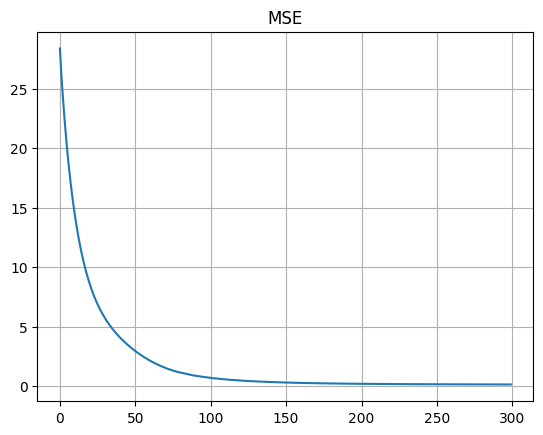

In [6]:
import matplotlib.pyplot as plt

plt.title("MSE")
plt.plot(np.array(tl))
plt.grid()
plt.show()

In [8]:
nonce_idx = torch.LongTensor(all_freq_nnf)
nonce_vecs = np.concatenate([netw.W(nonce_idx).detach().numpy(), netw.b(nonce_idx).detach().numpy(),
                             netw.Wc(nonce_idx).detach().numpy(), netw.bc(nonce_idx).detach().numpy()], axis=1)
nvdf = np.array(vectors_df.copy())
nvdf[all_freq_nnf] = nonce_vecs
nvdf = pd.DataFrame(nvdf)
nvdf.to_csv(FOLDER/'nonce-freq-joint.csv', sep='\t', encoding='utf-8')
nvdf

0         1         2         3         4         5         6    \
0     -0.000493  0.029432 -0.073276  0.200651 -0.170218 -0.097110 -0.105997   
1      0.053648 -0.081145  0.284485  0.120928 -0.093433 -0.049167  0.000374   
2      0.034252  0.100823  0.023131  0.061581 -0.091798 -0.112899 -0.114788   
3     -0.041380 -0.186123 -0.238965 -0.066747  0.186845  0.106081 -0.250341   
4     -0.168843  0.125099  0.076632  0.100672 -0.040765 -0.264709  0.264365   
...         ...       ...       ...       ...       ...       ...       ...   
20759 -0.025795  0.234238 -0.076611 -0.033742  0.100465 -0.221455  0.278392   
20760 -0.919250  1.688239 -0.502554 -0.400032 -0.158643 -0.895715 -0.877501   
20761 -0.187688  0.115590 -0.011260  0.217244  0.076753 -0.366490  0.280196   
20762 -0.091995 -0.075369 -0.024135  0.110620 -0.127078 -0.539675  0.236712   
20763 -0.001664  0.000190 -0.000144 -0.001634  0.000306 -0.000927 -0.001596   

            7         8         9    ...       592       593       594  \
0     -0.173410  0.193280 -0.154607  ...  0.022020  0.045551 -0.226583   
1     -0.324650  0.183834 -0.039084  ...  0.079693  0.007204 -0.044903   
2     -0.057552  0.080774 -0.194319  ...  0.048141  0.126965 -0.076789   
3     -0.182332  0.173760  0.034888  ...  0.093535 -0.220625 -0.280877   
4     -0.153585 -0.259497  0.296698  ... -0.109560  0.176415  0.346707   
...         ...       ...       ...  ...       ...       ...       ...   
20759 -0.138198  0.551552  0.089861  ... -0.301901 -0.065010  0.138358   
20760  0.349629  1.702033 -0.089058  ... -0.281719 -0.437948 -2.323274   
20761  0.084396  0.186494  0.254390  ... -0.031509 -0.009543 -0.242737   
20762  0.040846  0.499857  0.288973  ...  0.168737 -0.079603 -0.164294   
20763 -0.000373 -0.001149  0.000051  ...  0.000196  0.001009  0.001664   

            595       596       597       598       599       600       601  
0     -0.049600 -0.124576 -0.139002  0.008754  0.042013  0.039906  9.952419  
1      0.067786 -0.143698 -0.176114 -0.263069  0.074757  0.166795  7.601629  
2     -0.047092  0.010548 -0.105780 -0.081761 -0.129594 -0.026603  6.614210  
3      0.243746 -0.024856 -0.213180 -0.063363 -0.055134 -0.172561 -0.869568  
4     -0.181826 -0.765112 -0.367015  0.249050 -0.185705 -0.054963 -2.132403  
...         ...       ...       ...       ...       ...       ...       ...  
20759 -0.257259 -0.021323  0.000889 -0.080305 -0.359388  0.217326 -2.068346  
20760  0.462102  0.598756  0.642704 -0.045911 -1.003210  0.014638 -1.142698  
20761 -0.169332  0.258697  0.116010  0.012849 -0.339240 -0.001735 -3.483632  
20762 -0.114298  0.151122  0.061755  0.043134 -0.332331 -0.017255 -2.992071  
20763  0.000764  0.001435  0.000998  0.000133 -0.000660 -0.001262  0.001324  

[20764 rows x 602 columns]

In [9]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

db = DataBundle.load(FOLDER/'bundle.zip')
reset = db.nfs.reset_index()
nf_to_id = reset.set_index('nf').nf_n.to_dict()

vectors = []
words = []
for nf, nf_id in nf_to_id.items():
    if nf_id in all_freq_nnf:
        words.append(nf)
        vectors.append(nvdf.iloc[nf_id])
tsne_values = TSNE(n_components=2).fit_transform(np.array(vectors))

c:\users\alexandra\desktop\grammar_ru\venv\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\users\alexandra\desktop\grammar_ru\venv\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


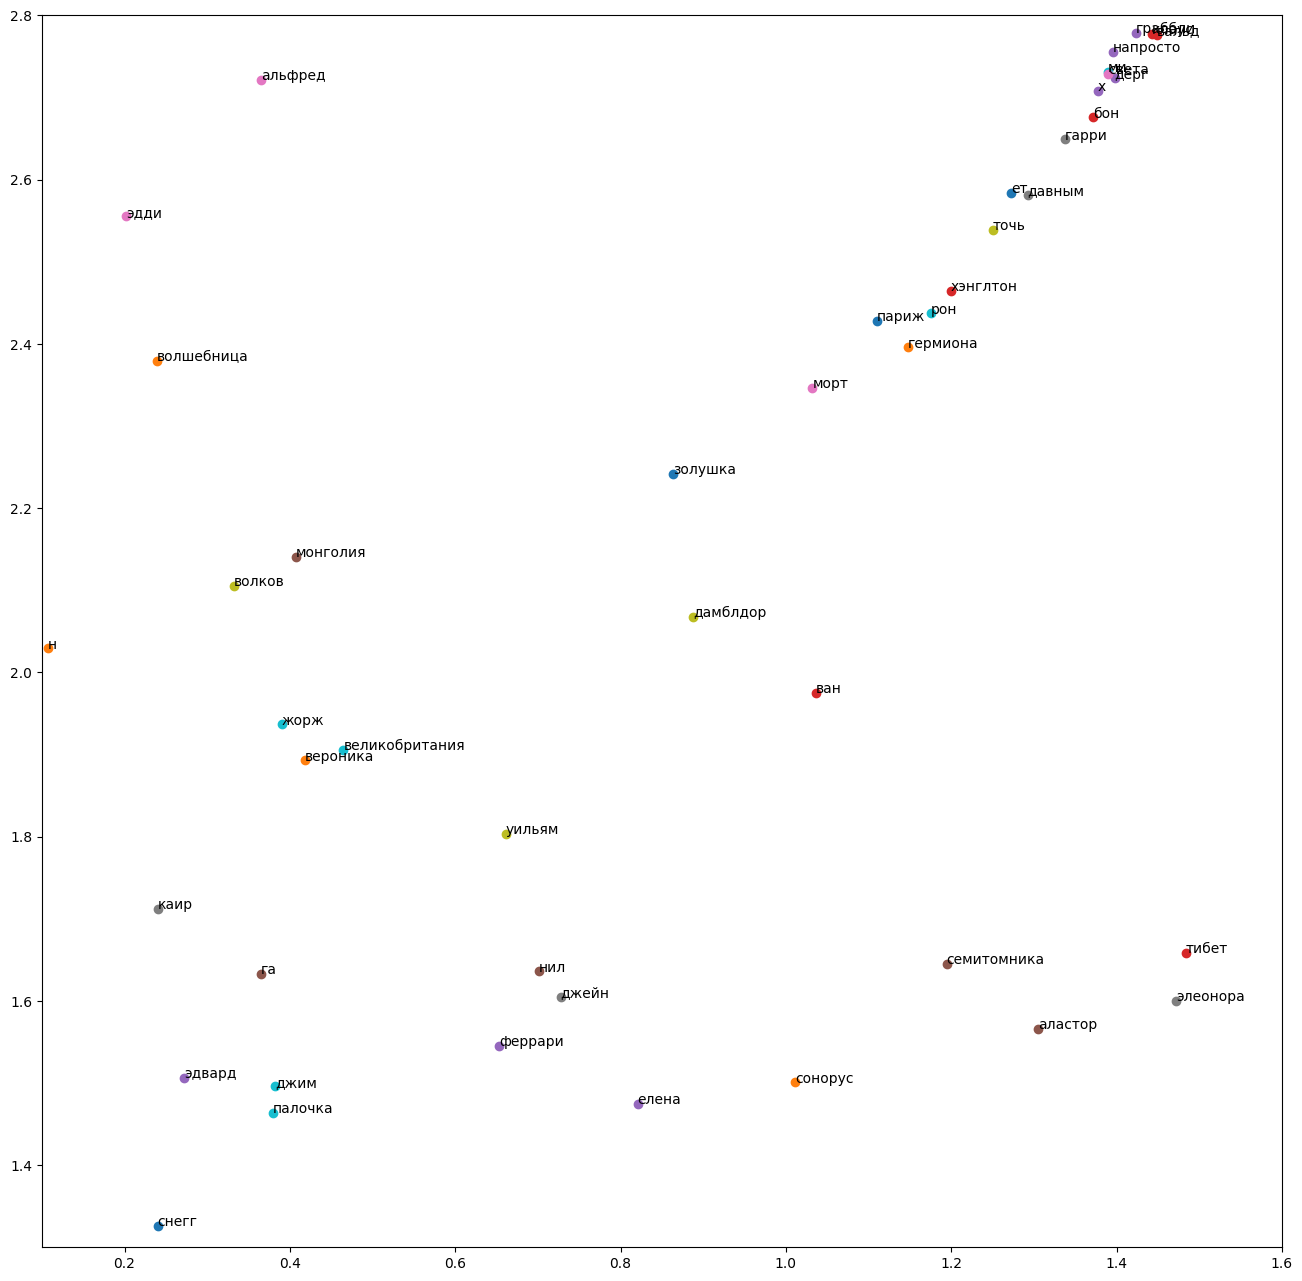

In [16]:
plt.figure(figsize=(16, 16))
for i in range(len(tsne_values)):
    x, y = tsne_values[i]
    plt.scatter(x, y)
    plt.annotate(words[i], xy=(x, y))
plt.ylim(1.3, 2.8)
plt.xlim(0.1, 1.6)
plt.show()

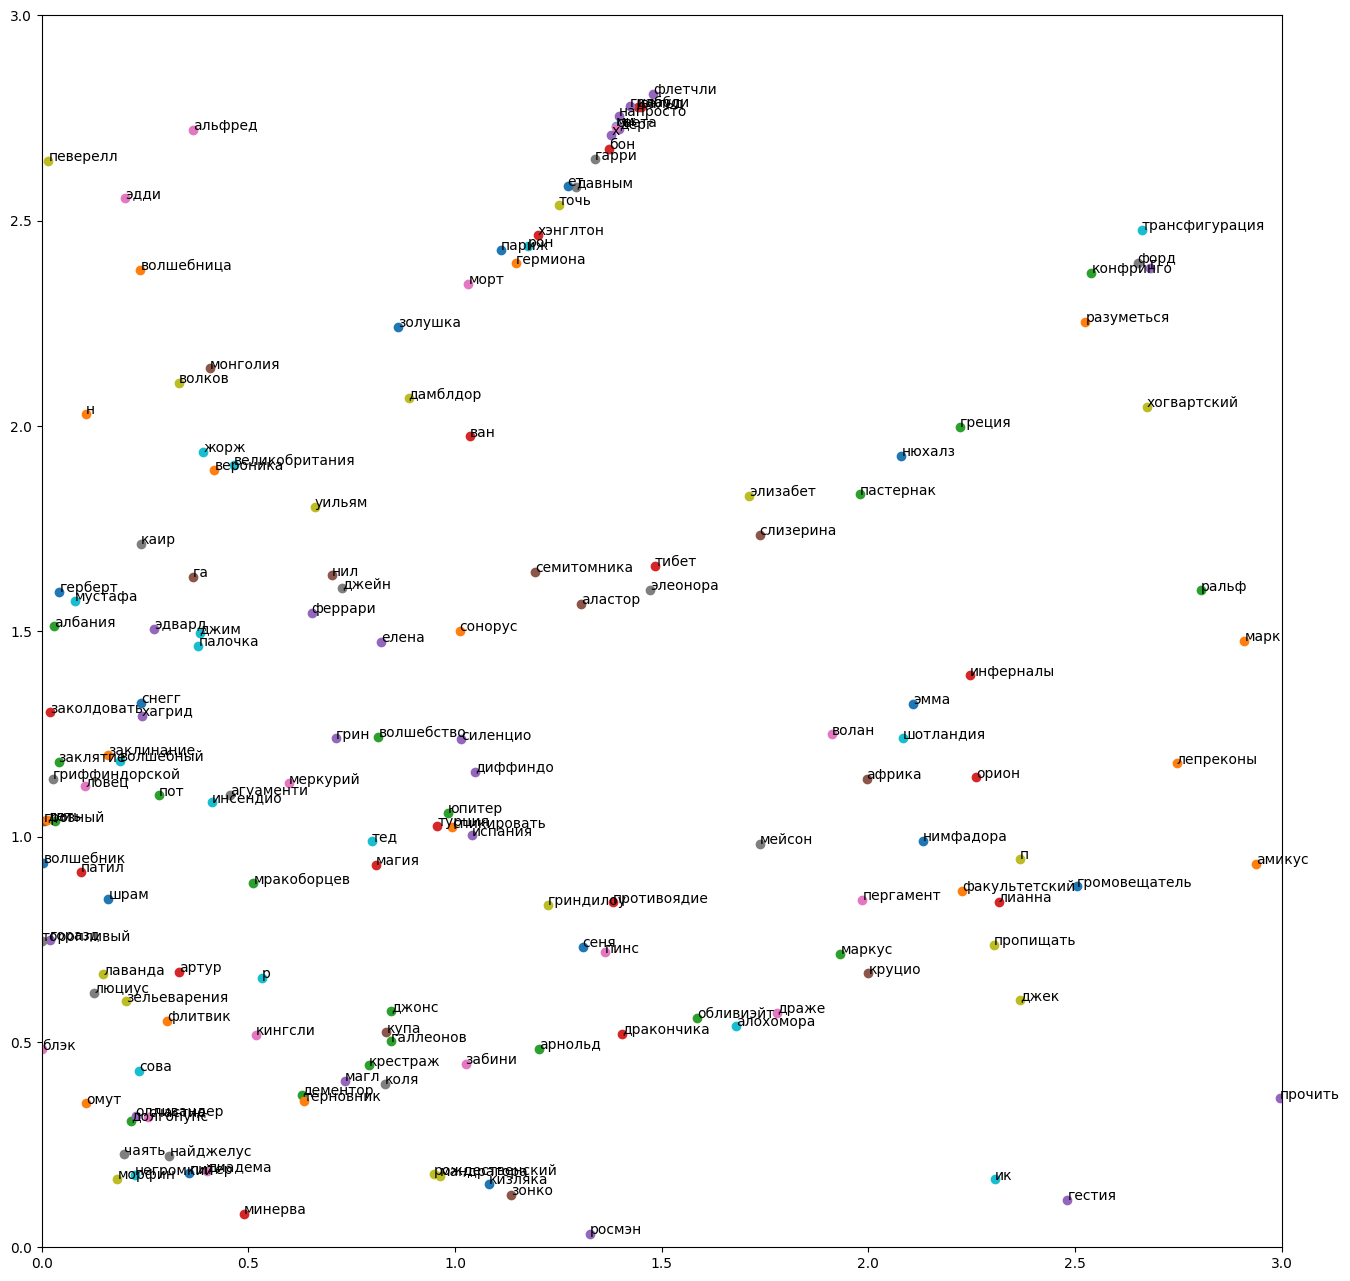

In [17]:
plt.figure(figsize=(16, 16))
for i in range(len(tsne_values)):
    x, y = tsne_values[i]
    plt.scatter(x, y)
    plt.annotate(words[i], xy=(x, y))
plt.ylim(0, 3)
plt.xlim(0, 3)
plt.show()

In [30]:
def get_cos_dist(x, y):
    x_mod = np.sum(x * x) ** 0.5
    y_mod = np.sum(y * y) ** 0.5
    return np.sum(x * y) / (x_mod * y_mod)

word_to_normal_form = db.words.set_index('word').nf_n.to_dict()
harry = nvdf.iloc[word_to_normal_form['гарри']]
potter = nvdf.iloc[word_to_normal_form['поттер']]
draco = nvdf.iloc[word_to_normal_form['драко']]
malfoy = nvdf.iloc[word_to_normal_form['малфой']]
mcgonagall = nvdf.iloc[word_to_normal_form['макгонагалл']]
snape =  nvdf.iloc[word_to_normal_form['снегг']]
gryffindor = nvdf.iloc[word_to_normal_form['гриффиндор']]
slytherin = nvdf.iloc[word_to_normal_form['слизерин']]
crabbe = nvdf.iloc[word_to_normal_form['крэбб']]
goyle = nvdf.iloc[word_to_normal_form['гойл']]
fred = nvdf.iloc[word_to_normal_form['фред']]
george = nvdf.iloc[word_to_normal_form['джордж']]

In [39]:
get_cos_dist(mcgonagall - gryffindor + slytherin, snape), ((mcgonagall - gryffindor) - (snape - slytherin)).sum()

(0.6141649391939964, 6.057211637344153)

In [32]:
get_cos_dist(crabbe, goyle), (crabbe - goyle).sum()

(0.7637287636752879, 0.9356499414425343)

In [33]:
ron = nvdf.iloc[word_to_normal_form['рон']]
get_cos_dist(harry, ron), (harry - ron).sum()

(0.8736761908661796, 0.08276590920286253)

In [34]:
get_cos_dist(fred, george), (fred - george).sum()

(0.9409945012644068, 0.5943011912168004)

In [36]:
get_cos_dist(harry, potter), (harry - potter).sum()

(0.6174830116218716, 3.7455278500565328)

In [40]:
get_cos_dist(harry - gryffindor + slytherin, draco), ((harry - gryffindor) - (draco - slytherin)).sum()

(0.2207970194545261, 15.035812031732348)

In [73]:
id_to_nf = {id: nf for nf, id in nf_to_id.items()}
taken_names = [id_to_nf[id] for id in all_freq_nnf]
del id_to_nf

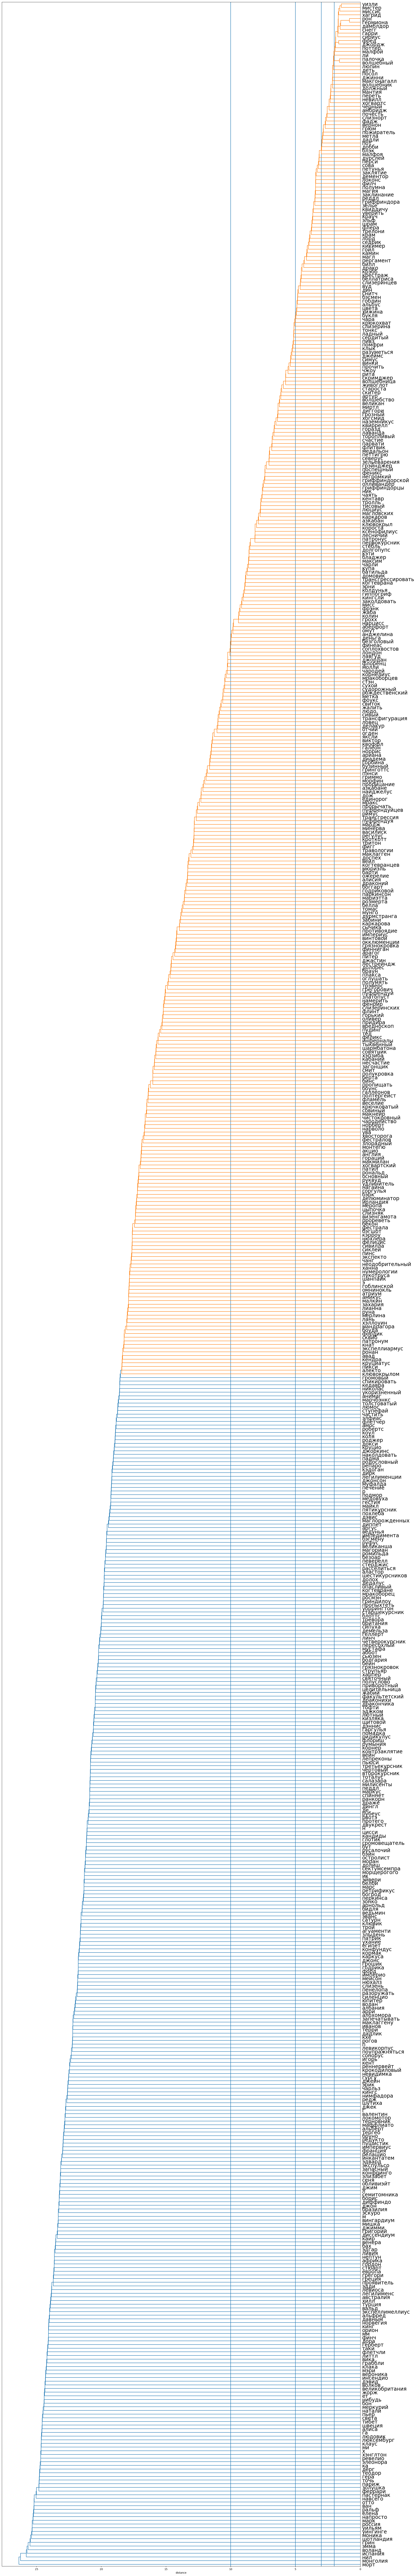

In [77]:
from scipy.cluster.hierarchy import dendrogram, linkage

plt.figure(figsize=(25, 180))
plt.xlabel('distance')
plt.vlines(2, 0, 10000)
plt.vlines(3, 0, 10000)
plt.vlines(5, 0, 10000)
plt.vlines(10, 0, 10000)

r = dendrogram(
    linkage(nvdf.iloc[all_freq_nnf], metric='euclidean'),
    leaf_font_size=20., 
    orientation='left',
    leaf_label_func=lambda v: taken_names[v]
)
plt.show()

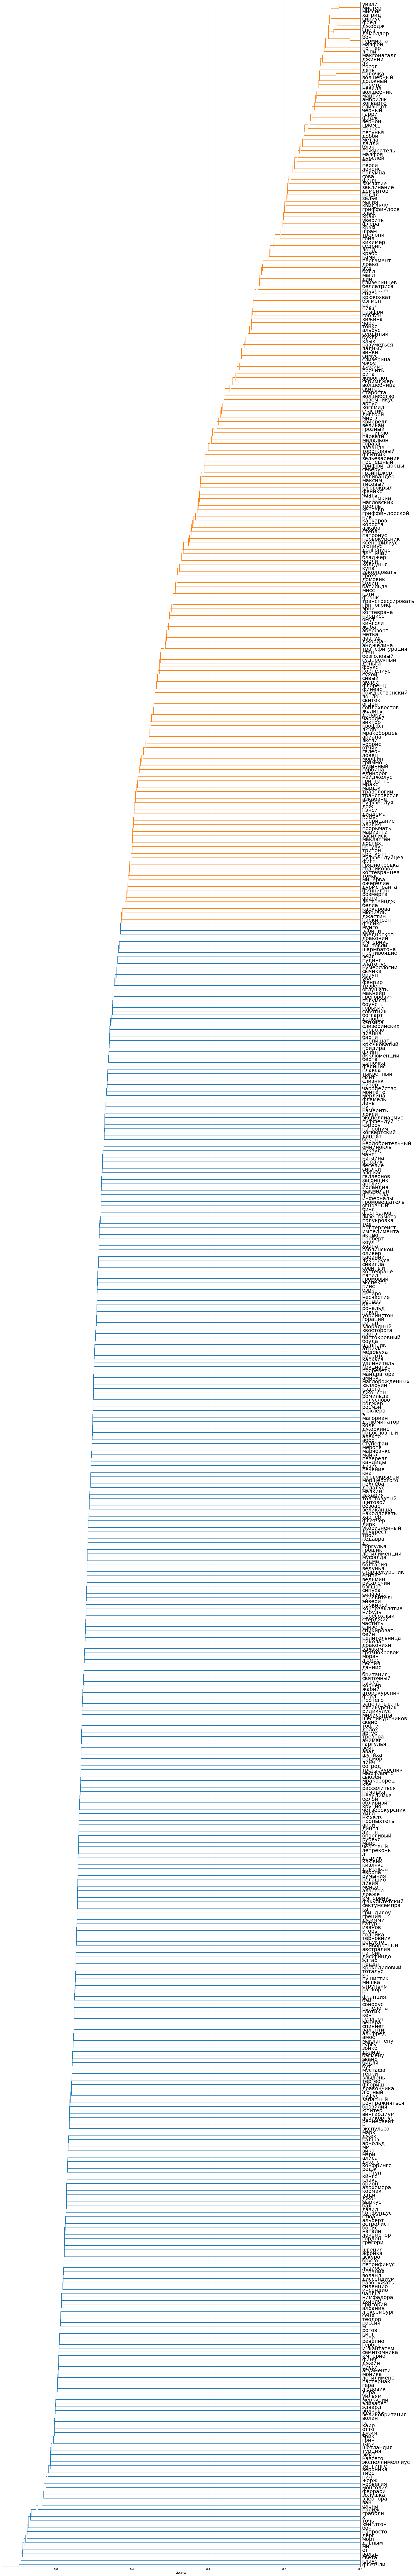

In [78]:
plt.figure(figsize=(25, 180))
plt.xlabel('distance')
plt.vlines(0.2, 0, 10000)
plt.vlines(0.3, 0, 10000)
plt.vlines(0.4, 0, 10000)

cos_r = dendrogram(
    linkage(nvdf.iloc[all_freq_nnf], metric='cosine'),
    leaf_font_size=20., 
    orientation='left',
    leaf_label_func=lambda v: taken_names[v]
)
plt.show()